In [222]:
import torch
import LightroomSettings as ls
import numpy as np
import seaborn as sns

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [223]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Detected {device} device")
model_path = "base.pth"


model_params = {
    'device': device,
    'path': model_path,
    'force_training': False,
}

training_params = {
    'learning rate' : 0.001,
    'num_epochs' : 6, 
    'criterion' : torch.nn.MSELoss(),
    'device' : device,
    'optimizer' : torch.optim.Adam,
    'log_training_to_console': True,
}

data_params = {
    'batch_size': 1,
    'num_of_dataloader_workers': 0,
    'shuffle_dataset': False,
    'flip_directions': [], # ['rot90', 'rot180', 'rot270','horizontal', 'rot90h', 'rot180h', 'rot270h'],
    'force_preprocessing': False,
    'random_cropping' : 0,
    'cropping_scale' : 0.85,
    'perspective_transform' : 0,
    'distortion_scale' : 0.2,
    'elastic_transform' : [], #[50.0,100.0,150.0,200.0]
    'gauss' : 0,
    "grid_mask":0,
    "grid_param":{"ratio":0.6, "d_min":30, "d_max":70},
    'sigma' : (0.1,5.0),
    "local_rotation":0,
    'validation_split' : [0.8, 0.2],
    'smooth_config': []  
}

Detected cuda device


In [224]:
model = ls.init_model(model_params)
data_loader, val_loader = ls.load_data('../data', data_params)

Model parameters loaded successfully
Loading tensors from file


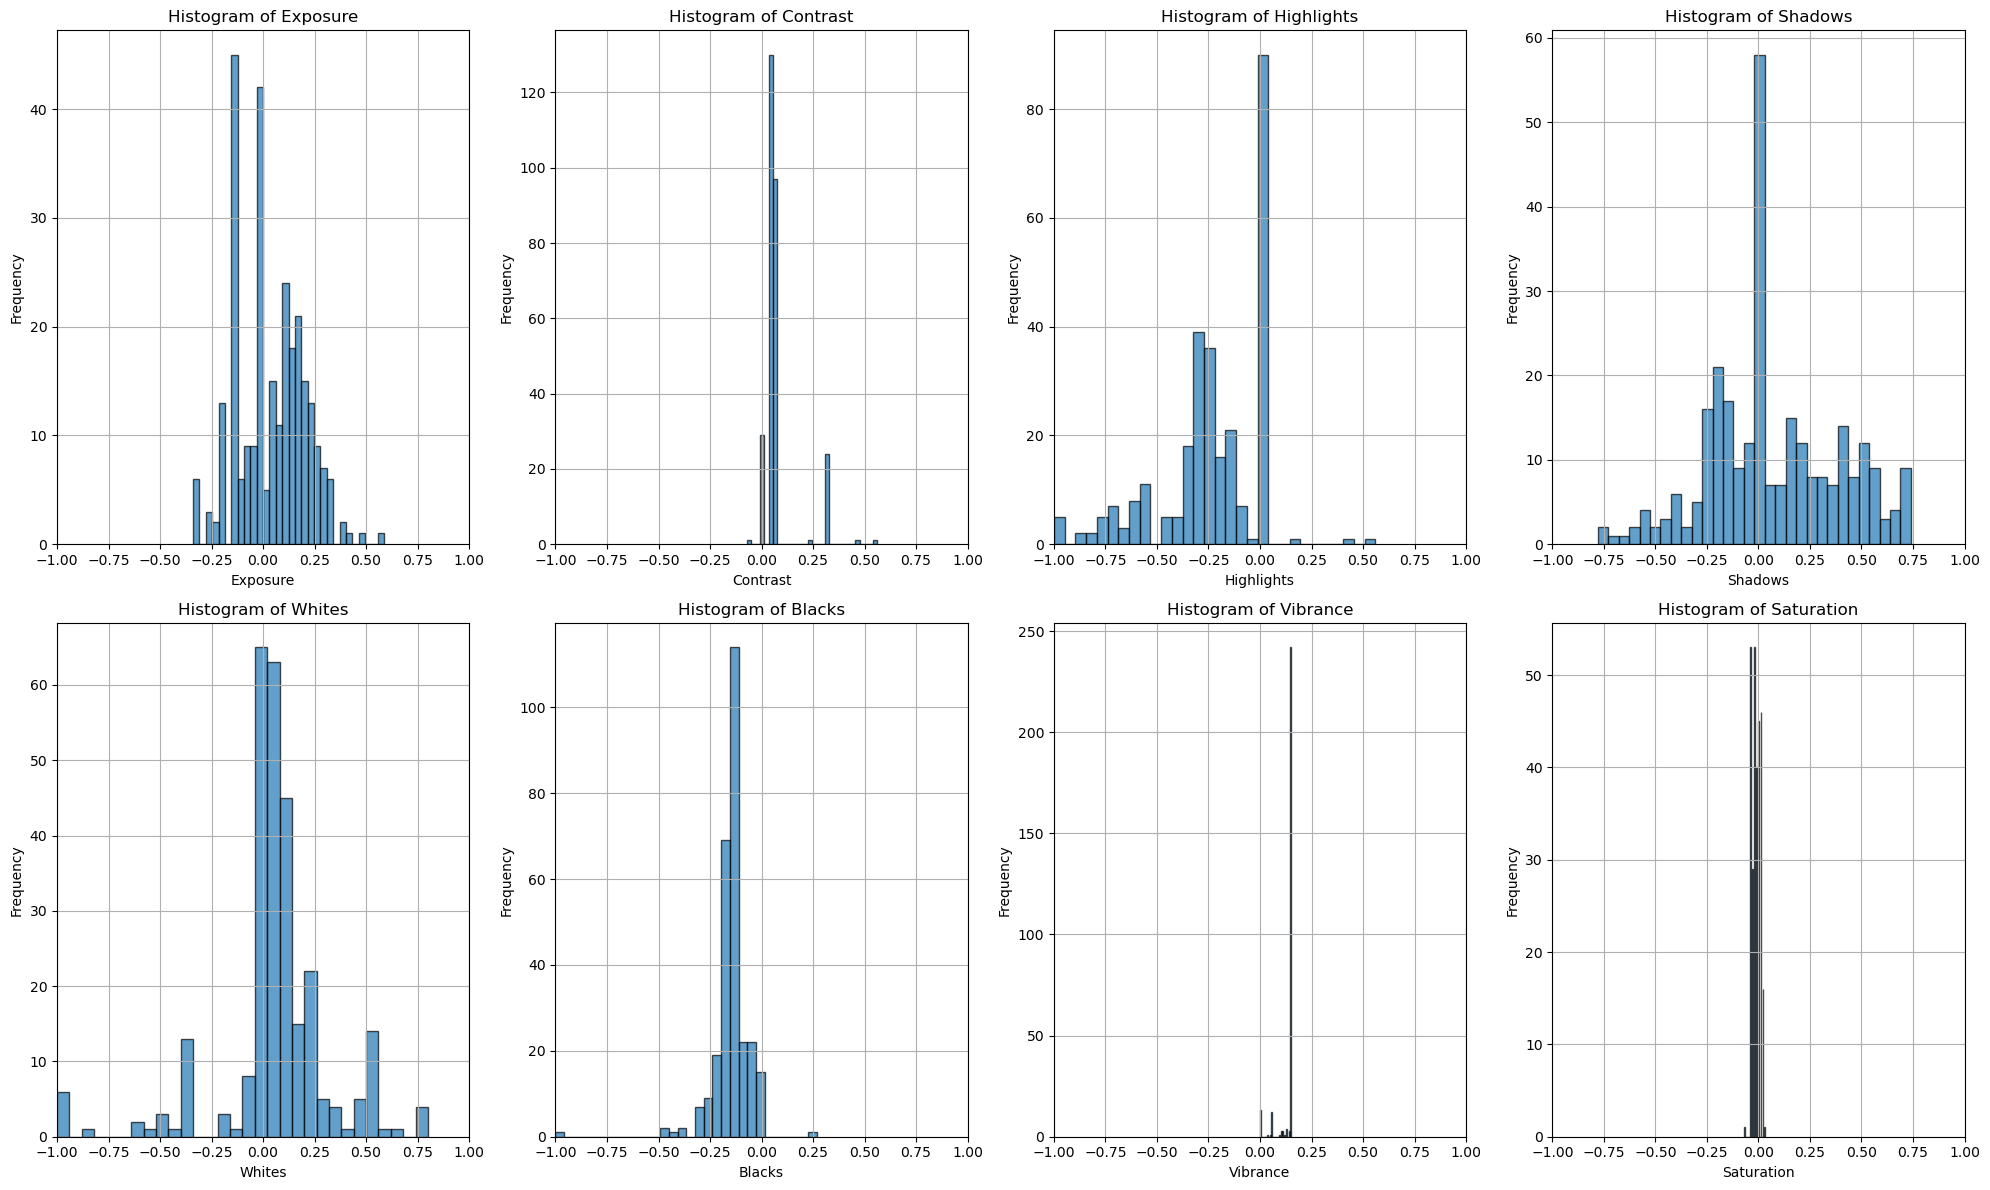

In [225]:
labels = ["Exposure", "Contrast", "Highlights", "Shadows", "Whites", "Blacks", "Vibrance", "Saturation"]


ls.plot_label_histograms(data_loader, labels)



In [226]:
len(data_loader)

284

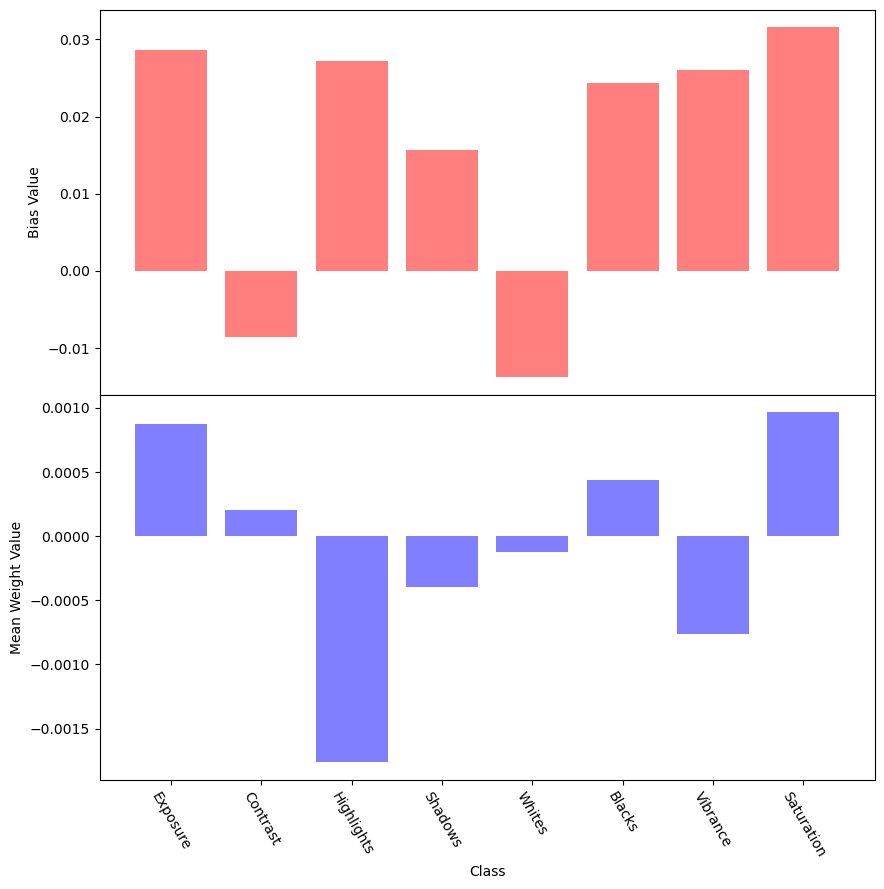

In [227]:
ls.plot_bias_and_linear_coefficients(model)

### Idea: Learn the labels by always guessing the average

Calculating average of training set

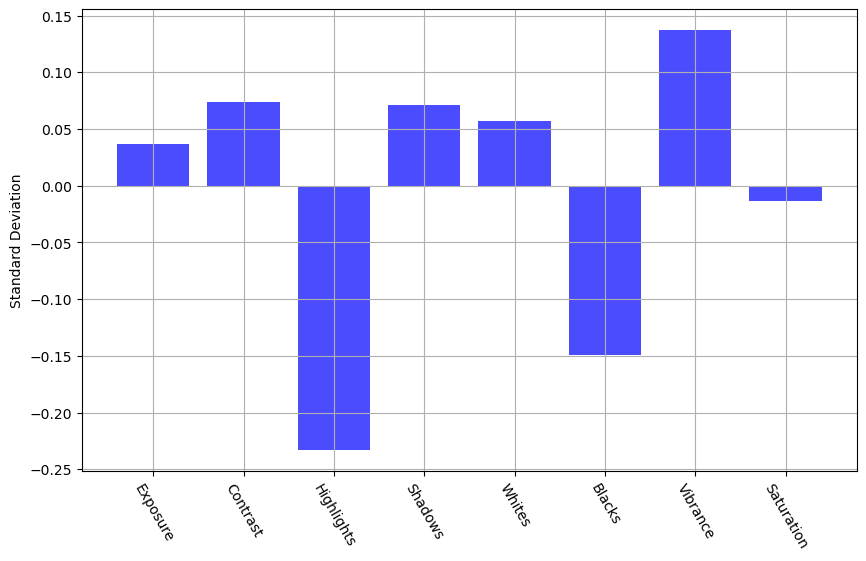

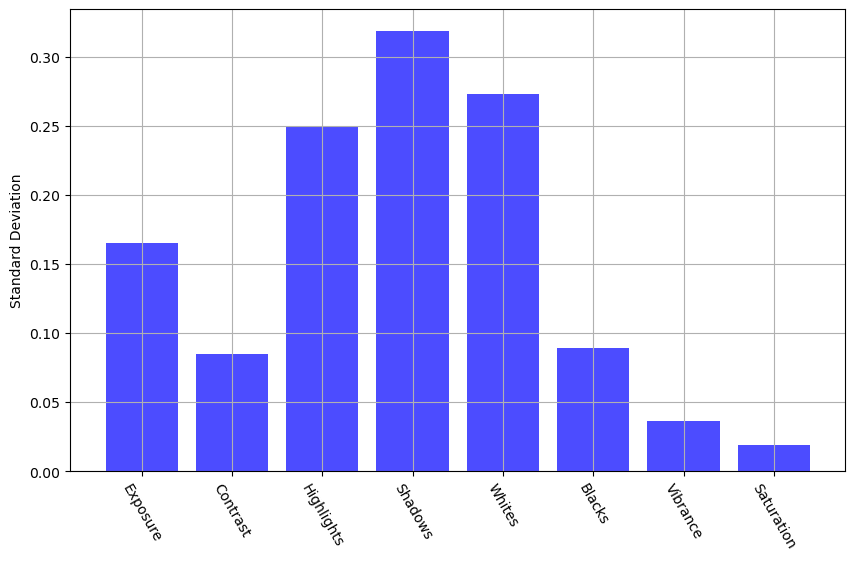

In [228]:
mean = ls.get_mean_of_set(data_loader)
std = ls.get_std_of_set(data_loader)

ls.bar_plot(mean)
ls.bar_plot(std)
    

In [229]:
all_labels = []
for img_tensors, img_labels in val_loader:
    img_labels = img_labels.cpu().numpy()
    all_labels.append(img_labels)

# Combine all labels into one array
all_labels_combined = np.concatenate(all_labels, axis=0)

In [230]:
num_vectors = 70
num_dimensions = 8

generated_vectors = np.random.normal(loc=mean, scale=std, size=(num_vectors, num_dimensions))


In [231]:
mse_loss = np.mean((all_labels_combined - generated_vectors) ** 2, axis=1)

# Calculate the average MSE loss
average_mse_loss = np.mean(mse_loss)
print(average_mse_loss)

0.08111805889584539


This is double the validationerror we usually get.

=> Networkt is better then random guessing
=> Network is usefull

### Visualizing Attention

Ground truth: [ 0.138  0.07  -0.3    0.01   0.43  -0.26   0.1    0.01 ]
Predicted: [ 0.09923891  0.01873302 -0.24804853 -0.00478715  0.42032245 -0.28869814
  0.08571762 -0.03627318]


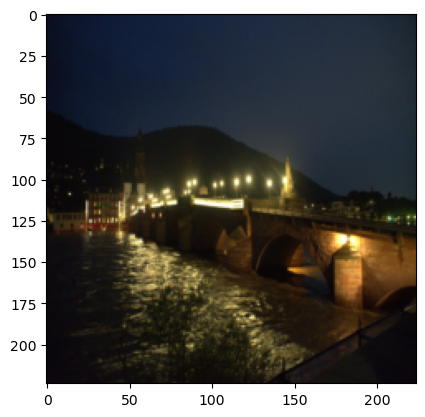

In [232]:
tensor, label = val_loader.dataset[5]

expl_tensor = tensor
expl_label = label

prediction = model(expl_tensor.unsqueeze(0))
logits = prediction.logits.detach().numpy().flatten()

print(f"Ground truth: {np.asarray(expl_label)}")
print(f"Predicted: {logits}")

plt.imshow(ls.tensor_to_image(expl_tensor))
plt.show()

In [233]:
def plot_all_attention_heads(attentions):
    num_layers = int(len(attentions) / 2)
    num_heads = int(attentions[0].shape[1] / 2)  # assuming all layers have the same number of heads

    print(f"Number of layers: {num_layers}")
    print(f"Number of heads: {num_heads}")

    fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads * 5, num_layers * 5))

    for layer in range(num_layers):
        for head in range(num_heads):
            attention = attentions[2 * layer][0, 2 * head].detach().cpu().numpy()
            ax = axes[layer, head]
            sns.heatmap(attention, cmap='viridis', ax=ax)
            ax.set_title(f'Layer {2 * layer + 1} Head {2 * head + 1}')
            ax.set_xlabel('Tokens')
            ax.set_ylabel('Tokens')

    plt.tight_layout()
    plt.show()

Number of layers: 4
Number of heads: 4


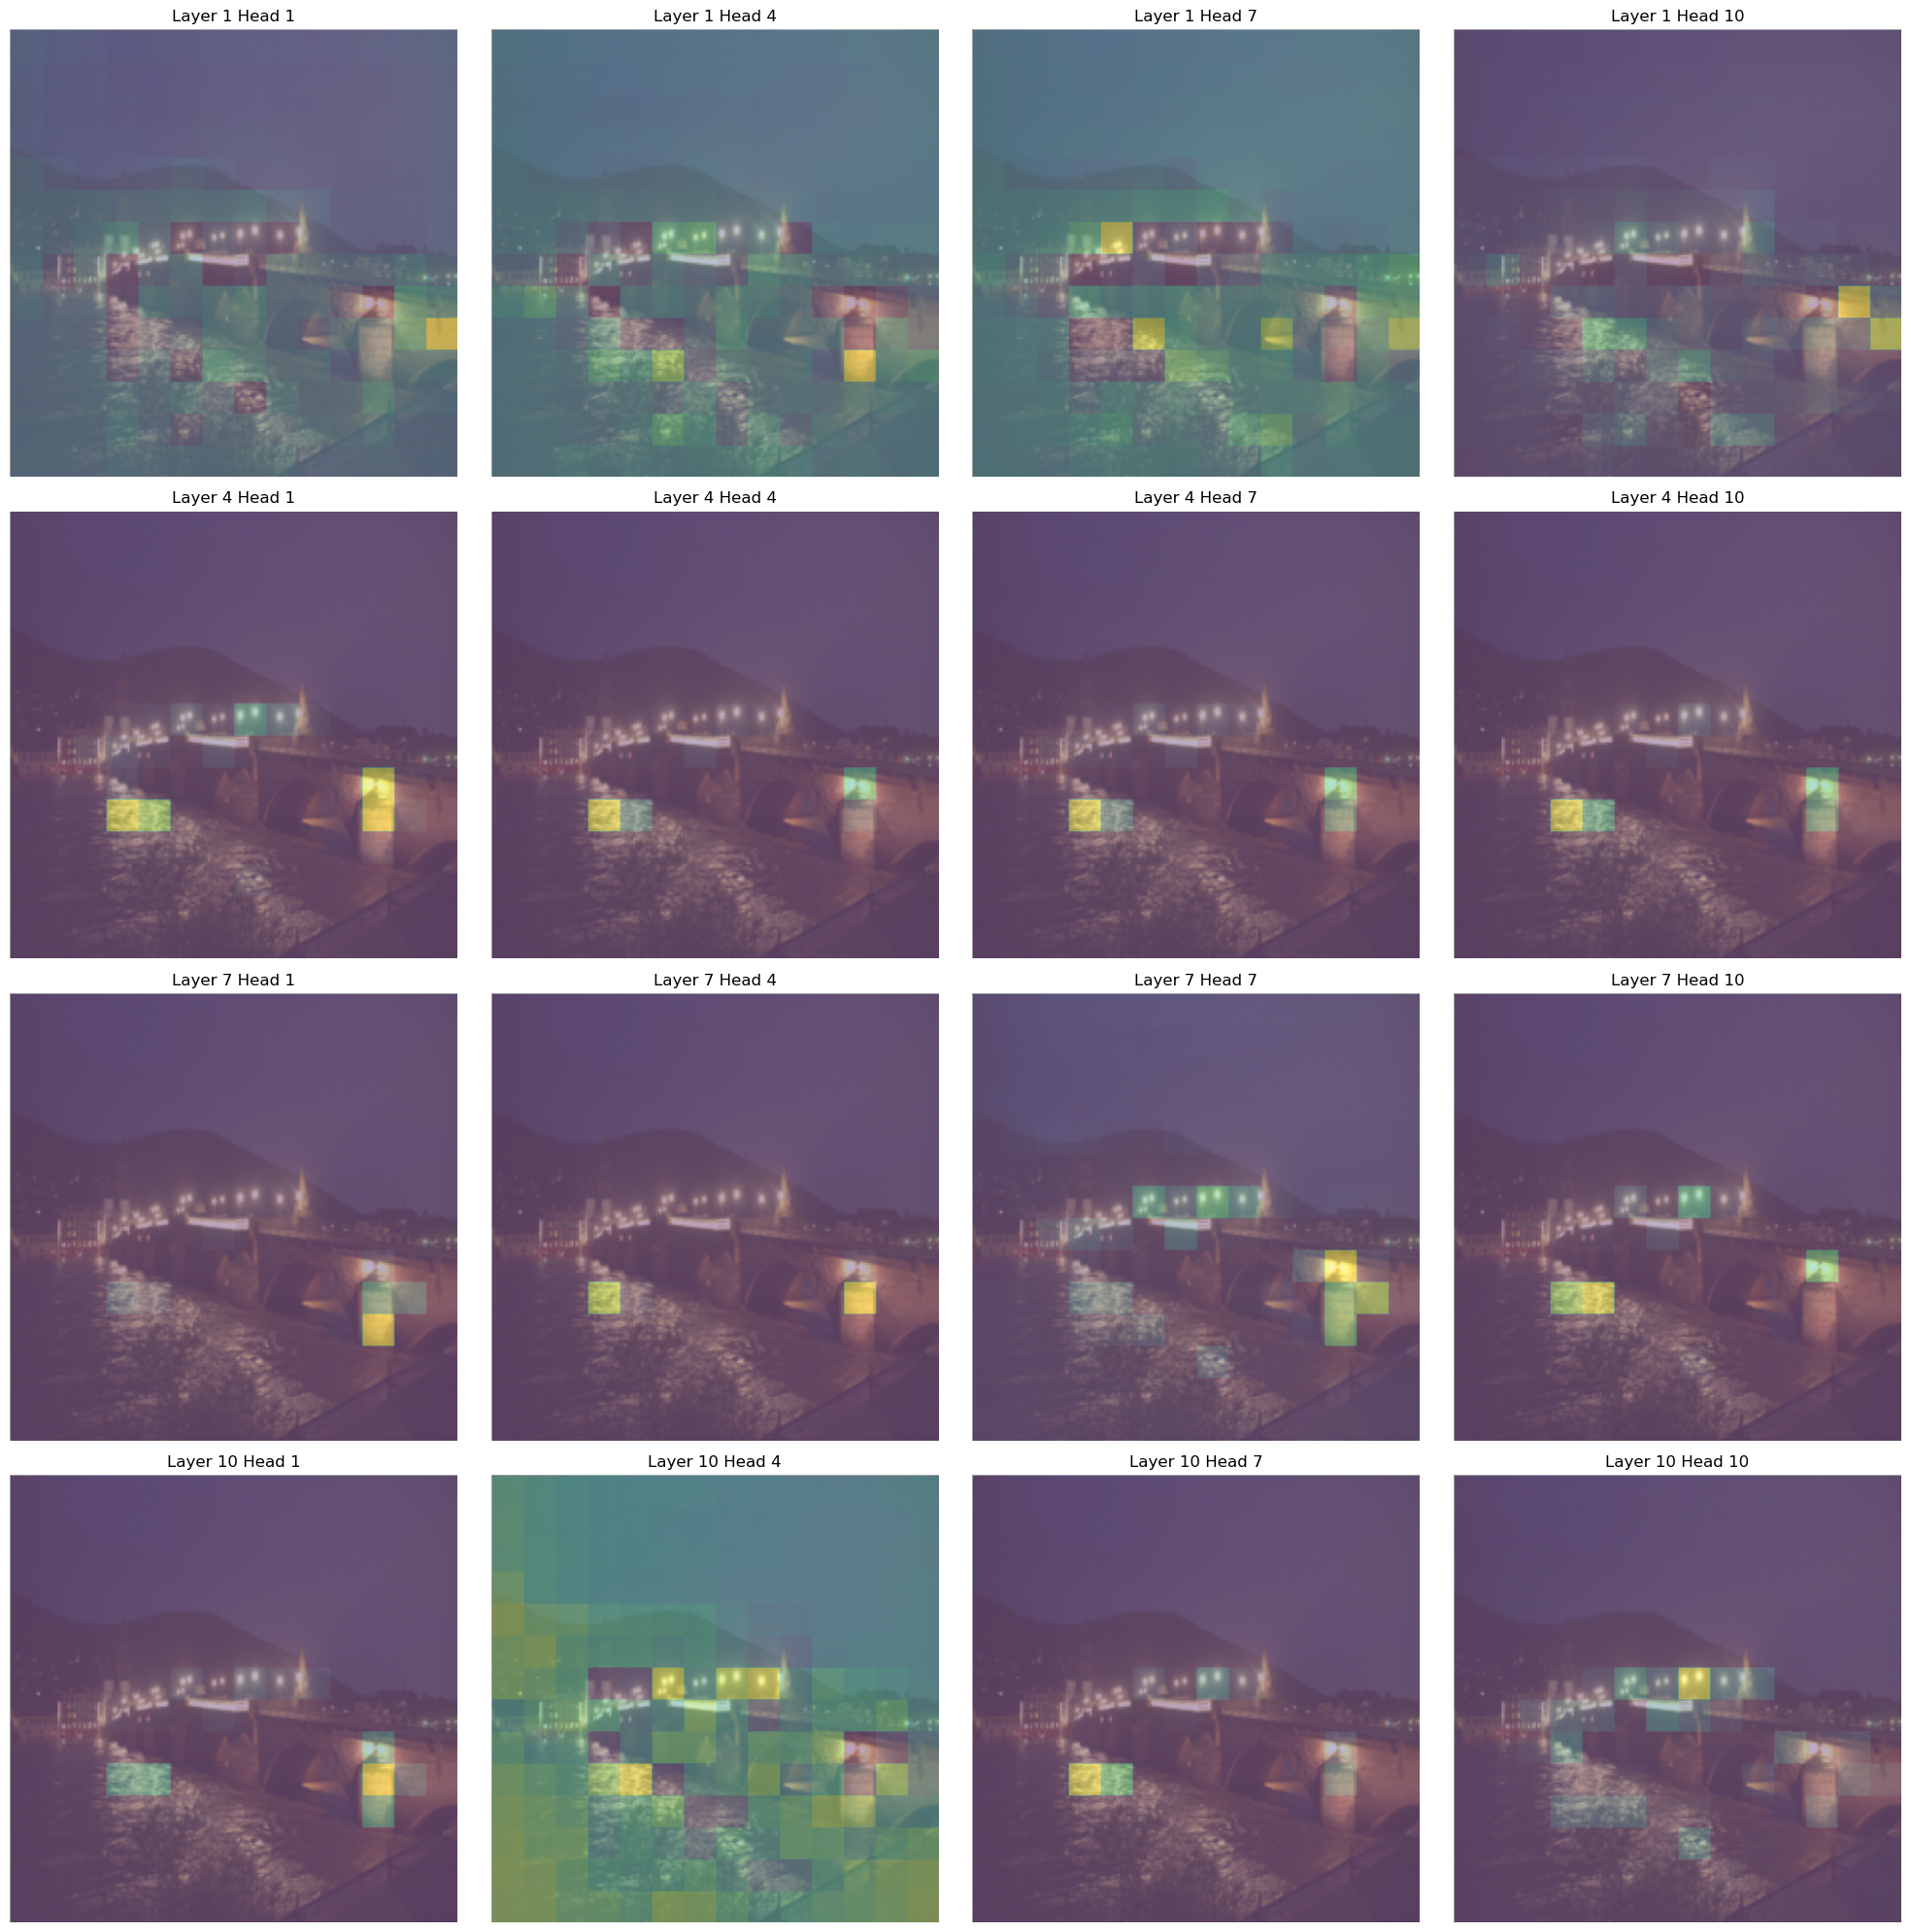

In [234]:
def plot_attention_heads_overlay(tensor, attentions, n = 4):
    num_layers = int(len(attentions) / n)
    num_heads = int(attentions[0].shape[1] / n)  # assuming all layers have the same number of heads

    print(f"Number of layers: {num_layers}")
    print(f"Number of heads: {num_heads}")

    fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads * 5, num_layers * 5))

    for layer in range(num_layers):
        for head in range(num_heads):
            attention = attentions[n * layer][0, n * head].detach().cpu().numpy()
            cls_attention = attention[0, 1:].reshape(14, 14)
            cls_attention = cls_attention / cls_attention.max()  # Normalize for visualization
            cls_attention = np.kron(cls_attention, np.ones((16, 16)))  # Upsample to match image size
            
            ax = axes[layer, head]
            ax.imshow(cls_attention, cmap='viridis', alpha=0.6, extent=(0, 224, 224, 0))
            ax.imshow(ls.tensor_to_image(tensor), alpha=0.4)
            ax.set_title(f'Layer {n * layer + 1} Head {n * head + 1}')
            ax.set_xlabel('Tokens')
            ax.set_ylabel('Tokens')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_attention_heads_overlay(expl_tensor, prediction.attentions, n = 3)